# 1. Import necessary libraries

Machine Learning in Python with scikit-learn
COVID dataset analysis (regression problem)
Author: Irina Chelysheva, ipynb edited version from Kristian Gurashi

Date: Dec 5th, 2025
COVID dataset extracted from OurWorldInData (https://github.com/owid/covid-19-data)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#We will include linear models with regularization techniques to shrink coefficients and prevent overfitting. 
#Ridge will penalize large coefficients by adding a penalty equivalent to the square of the magnitude of coefficients. 
#Lasso will perform both variable selection and regularization by adding a penalty equivalent to the absolute value of the magnitude of coefficients. Lasso doesn't know which feature to remove if highly correlated.
#ElasticNet combines both Lasso and Ridge penalties.

# 2. Set working directory, load, explore and prepare the dataset

In [2]:
# Identifying script folder
cwd = os.getcwd()

# Defining work directory
wd = os.path.dirname(cwd)

# Defining data directory
data_dir = os.path.join(wd, 'Data')

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'ML', 'owid_covid_for_ML_short.csv'))
print("Total data points",df.shape[0])
print("Total number of features(as number of columns) are ", df.shape[1])
df.describe()
df.head()

Total data points 179
Total number of features(as number of columns) are  16


,deaths_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,hdi
0,62.422,38928341,54.422,18.600000,2.581000,1.33700,1803.98700,13.64958,597.029,9.59,10.556204,32.139259,37.746000,0.500000,64.83,0.511
1,568.490,2877800,104.871,38.000000,13.188000,8.64300,11803.43100,1.10000,304.195,10.08,7.100000,51.200000,50.315364,2.890000,78.57,0.795
2,67.364,43851043,17.348,29.100000,6.211000,3.85700,13913.83900,0.50000,278.364,6.73,0.700000,30.400000,83.741000,1.900000,76.88,0.748
3,1384.844,77265,163.755,30.429885,8.723994,5.53022,18901.21359,13.64958,109.135,7.97,29.000000,37.800000,50.315364,3.017472,83.73,0.868
4,15.152,32866268,23.890,16.800000,2.405000,1.36200,5819.49500,13.64958,276.045,3.94,10.556204,32.139259,26.664000,3.017472,61.15,0.581


In [4]:
#Check for null values
null_values = df.isnull().values.any()
if null_values == True:
    print("There are some missing values in data")
else:
    print("There are no missing values in the dataset")

There are no missing values in the dataset


In [5]:
# Check skewness of the data
skewness_before = df.select_dtypes(include=np.number).apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness before transformation:")
print(skewness_before)

Skewness before transformation:
population_density            10.894526
population                     8.096116
extreme_poverty                1.982488
gdp_per_capita                 1.900905
hospital_beds_per_thousand     1.876996
deaths_per_million             1.210881
female_smokers                 1.102400
diabetes_prevalence            0.953387
aged_70_older                  0.947928
cardiovasc_death_rate          0.913280
aged_65_older                  0.816593
male_smokers                   0.470396
median_age                     0.105529
handwashing_facilities        -0.041661
hdi                           -0.390869
life_expectancy               -0.564639
dtype: float64


# 3. Log-transform numeric features to reduce skewness and stabilize variance

In [6]:
#Note: ignore non-numeric columns
for column in df.select_dtypes(include=np.number).columns:
    df[column] = df[column].apply(lambda x: np.log10(x) if x > 0 else x)

In [7]:
# Check skewness after transformation
skewness_after = df.select_dtypes(include=np.number).apply(lambda x: x.skew()).sort_values(ascending=False)
print("\nSkewness after transformation:")
print(skewness_after)


Skewness after transformation:
population_density            0.080159
aged_65_older                 0.034440
aged_70_older                 0.021404
cardiovasc_death_rate        -0.192725
median_age                   -0.261286
gdp_per_capita               -0.411615
population                   -0.429903
diabetes_prevalence          -0.571146
extreme_poverty              -0.610222
hospital_beds_per_thousand   -0.673010
deaths_per_million           -0.696034
hdi                          -0.733648
life_expectancy              -0.768985
male_smokers                 -0.812564
female_smokers               -0.896997
handwashing_facilities       -2.123274
dtype: float64


In [8]:
# Define feature matrix X and target variable y
X = df.drop("deaths_per_million", axis=1)  # Feature Matrix
y = df["deaths_per_million"]  # Target Variable

# 4. Split the dataset into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# 5. Optional: exploration and feature selection using Pearson Correlation

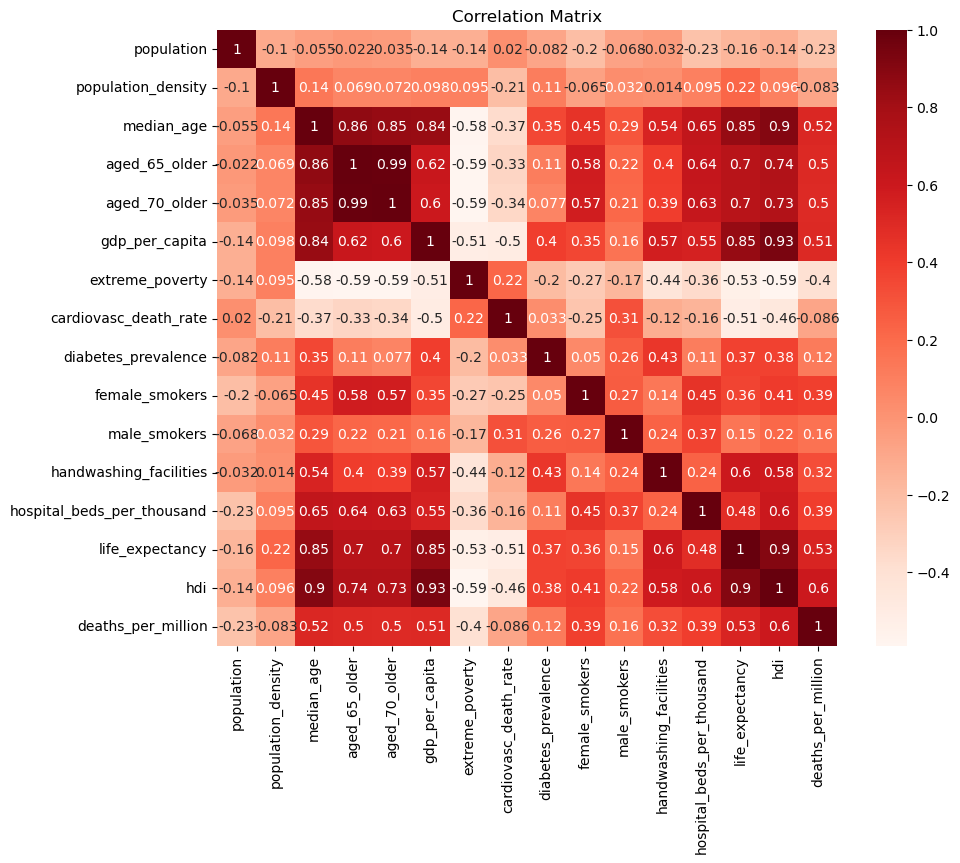

In [10]:
# Combine X_train and y_train for correlation analysis
all_train = pd.concat([X_train, y_train], axis=1)
# Run and plot correlations
cor = all_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Matrix')
plt.show()

In [11]:
# You can select features highly correlated with the target variable
cor_target = abs(cor["deaths_per_million"])
relevant_features = cor_target[cor_target > 0.5].index.tolist()
print(f"Highly correlated features with target: {relevant_features}")

Highly correlated features with target: ['median_age', 'aged_65_older', 'gdp_per_capita', 'life_expectancy', 'hdi', 'deaths_per_million']


In [12]:
# Or you can check and remove multicollinear features
multicollinearity_pairs = [
    ("median_age", "life_expectancy"), 
    ("life_expectancy", "aged_65_older"),
    ("gdp_per_capita", "hdi"),          
]

In [13]:
# Loop through the pairs and print the correlation
for pair in multicollinearity_pairs:
    print(f"Correlation between {pair[0]} and {pair[1]}:\n", all_train[[pair[0], pair[1]]].corr(), "\n")

Correlation between median_age and life_expectancy:
                  median_age  life_expectancy
median_age         1.000000         0.847597
life_expectancy    0.847597         1.000000 

Correlation between life_expectancy and aged_65_older:
                  life_expectancy  aged_65_older
life_expectancy         1.000000       0.700669
aged_65_older           0.700669       1.000000 

Correlation between gdp_per_capita and hdi:
                 gdp_per_capita       hdi
gdp_per_capita        1.000000  0.932124
hdi                   0.932124  1.000000 



# 6. Choosing the best regression model using selected features

In [14]:
# Subset data based on feature selection (we won't subset - try at home)
Xa_train = X_train
Xa_test = X_test
ya_train = y_train
ya_test = y_test

In [15]:
# Define models for evaluation
models = [
    ('LR', LinearRegression()), 
    ('R', Ridge()), 
    ('LASSO', Lasso()), 
    ('EN', ElasticNet()), 
    ('KN', KNeighborsRegressor()), 
    ('DTR', DecisionTreeRegressor(random_state=1)), 
    ('SVR', SVR(gamma='auto')),
    ('RF', RandomForestRegressor(random_state=1))
]

In [16]:
# Evaluate each model using 10-fold cross-validation
seed = 7
scoring = 'neg_mean_squared_error'
results, names = [], []
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [17]:
print("Model Evaluation Results:")
for name, model in models:
    cv_results = cross_val_score(model, Xa_train, ya_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name}: Mean MSE = {cv_results.mean():.4f} (Std = {cv_results.std():.4f})')

Model Evaluation Results:
LR: Mean MSE = -0.5534 (Std = 0.2126)
R: Mean MSE = -0.5741 (Std = 0.2206)
LASSO: Mean MSE = -0.8578 (Std = 0.3040)
EN: Mean MSE = -0.8578 (Std = 0.3040)
KN: Mean MSE = -0.6654 (Std = 0.3144)
DTR: Mean MSE = -1.2056 (Std = 0.4951)
SVR: Mean MSE = -0.5910 (Std = 0.3128)
RF: Mean MSE = -0.5373 (Std = 0.2796)


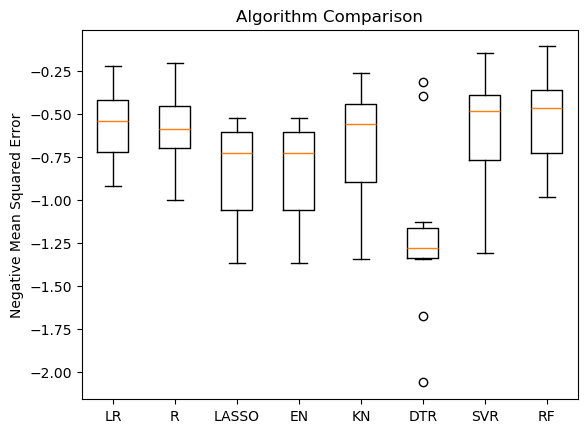

In [18]:
# Plot the comparison of model performance
plt.boxplot(results, tick_labels=names)
plt.title('Algorithm Comparison')
plt.ylabel('Negative Mean Squared Error')
plt.show()

# 7. Train the best-performing model and evaluate it (hint: you can also try Ridge on your own)

In [19]:
best_model = RandomForestRegressor()
best_model.fit(Xa_train, ya_train)
predictions = best_model.predict(Xa_test)

# 8. Evaluate the model using various metrics

In [21]:
mse = mean_squared_error(ya_test, predictions)
mae = mean_absolute_error(ya_test, predictions)
r2 = r2_score(ya_test, predictions)

In [22]:
print("\nBest Model Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Mean of ya_test: {ya_test.mean():.4f}")


Best Model Evaluation on Test Set:
Mean Squared Error (MSE): 0.5995
Mean Absolute Error (MAE): 0.5460
R^2 Score: 0.2931
Mean of ya_test: 2.0518


# 9. Plot Actual vs. Predicted Values

In [23]:
# Reverse the log10 transformation for plotting
ya_test_exp = 10 ** ya_test
predictions_exp = 10 ** predictions

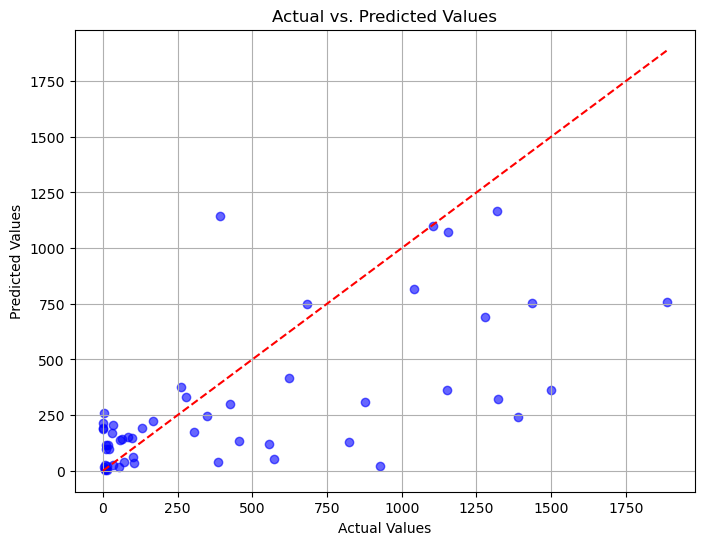

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(ya_test_exp, predictions_exp, color='blue', alpha=0.6)
plt.plot([min(ya_test_exp), max(ya_test_exp)], [min(ya_test_exp), max(ya_test_exp)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

# Further exploration

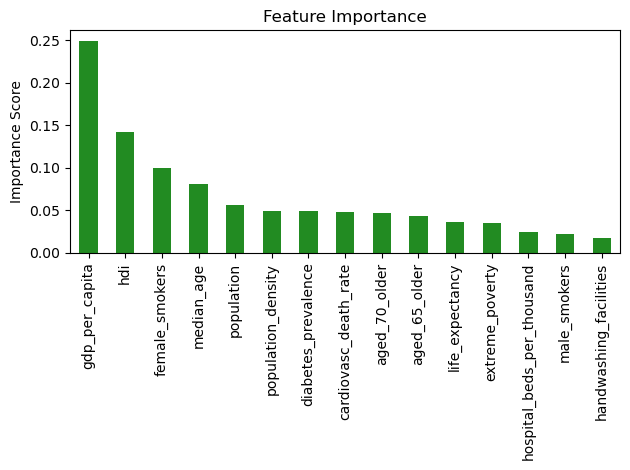

In [25]:
# Feature Importance
feature_importance = pd.Series(best_model.feature_importances_, index=Xa_train.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='forestgreen')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()
#Note1: we calculate the decrease in impurity (MDI) across all trees, e.g. how much each feature contributes to reducing the prediction error
#Note2: it doesn't indicate the direction of the relationship (unlike in LM)

In [26]:
# Comparison Table
results_df = pd.DataFrame({'Actual': ya_test_exp, 'Predicted': predictions_exp})
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
print(results_df.head(10))  # Display the first 10 results

       Actual   Predicted        Error
114    70.735   39.332610    31.402390
85     33.717   26.208164     7.508836
97     10.545   10.276880     0.268120
160     9.436   97.018305   -87.582305
35   1149.915  361.377770   788.537230
54    555.094  119.620528   435.473472
124   384.403   38.521951   345.881049
19      1.296  214.278560  -212.982560
108     0.610  194.156690  -193.546690
125  1323.594  323.271740  1000.322260


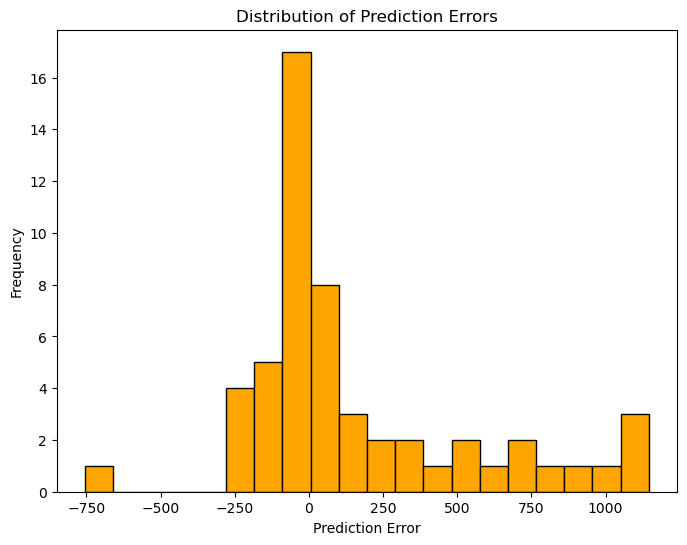

In [27]:
# Histogram of Prediction Errors
plt.figure(figsize=(8, 6))
plt.hist(results_df['Error'], bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()